# Сборный проект 2. "Анализ поведения пользователей мобильного приложения по доставке продуктов питания"

Проект посвящен анализу поведения пользователей мобильного приложения, в котором продаются продукты питания. Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? Также предполагается проведение A/A/B-теста, который должен показать целеообразность изменеия шрифтов во всем приложении.

**План работы:**
1. [Изучить общую информацию о данных;](#start)
2. [Предобраобработка данных](#pre_processing)
3. [Изучение и проверка данных;](#research_analysis)
     - [изучение количества событий и пользователей в логе;](#count_events)    
     - [проверка полноты данных за период, графики](#analazed_period)
     - [анализ исключений](#checking)
     - [анализ количества пользователей в разрезе экспериментальных групп](#experimen_group)
4. [Анализ воронки событий](#event_funnel)
     - [оценка частоты событий в логах](#event_log)
     - [анализ событий в разрезе пользователей](#event_users)
     - [анализ цепочки событий](#chain_of_events)
     - [построение воронки событий](#conversion)
5. [А/А/В эксперимент](#experiment)
     - [подсчет количества пользователей в каждой экприментальной группе](#cont_group)
     - [оценка статистической значимости между контрольными группы для А/А-эксперимента](#A_A)
     - [A/B тест](#A_B)
6. [Вывод](#resume)

## 1. Изучение общей информации <a id="start"> </a>

In [21]:
import pandas as pd # <импорт библиотеки pandas>

import matplotlib.pylab as plt # <импорт библиотеки matplotlib>
import numpy as np # <импорт библиотеки numpy>
import seaborn as sns #<импорт библиотеки seaborn>
import scipy.stats as st  # <импорт scipy.stats>
from IPython.display import display# <импорт метода display из библиотеки IPython.display для просмотра таблиц>
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import pylab as pl
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
import re
from datetime import datetime, date, time
import math as mth
from pandas.plotting import register_matplotlib_converters

Прочитаем файл logs_exp.csv

In [22]:
logs_exp = pd.read_csv('E:\csv_mobil_pril\logs_exp.csv', sep='\t')
 # <чтение файла с данными с сохранением их в переменной logs_exp, с указанием разделителя>

Посмотрим таблицу logs_exp, выведем ее на экран

In [23]:
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Данные в столбце EventTimestamp отобразились в формате unix time

Посмотрим общую информацию о таблице

In [24]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [25]:
logs_exp['ExpId'].unique()

array([246, 248, 247], dtype=int64)

Таблица содержит 4 столбца и 244126 строк, пропущенные значения отсутствуют, неверно указан тип данных столбца EventTimestamp содержащшего информацию о дате и времени события. Информация в столбце ExpId указана верно (в нем должно быть 3 уникальных номера экспериментальных групп). Названия столбцов необходимо открректировать.

## Вывод

В данных отсутствуют пропущенные значения, это хорошо - данные полные, но они нуждаются в предобработке - необходимо изменить названия столбцов и тип данных EventTimestamp привести к datatime

## 2. Предобработка данных <a id="pre_processing"> </a>

Изменим названия столбцов, для этого передадим новый спискок имен

In [26]:
logs_exp.columns = ['event_name','user_id', 'event_date_time', 'exp_id']

Изменим тип данных столбца event_date на datetime

In [27]:
logs_exp['event_date_time'] = pd.to_datetime(logs_exp['event_date_time'], unit='s')#<изменение типа данных на datetime>

In [80]:
logs_exp.head()

,event_name,user_id,event_date_time,exp_id,event_date,event_time,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42,11


Добавим столбец даты и времени

In [29]:
logs_exp['event_date']= logs_exp['event_date_time'].dt.date
logs_exp['event_time']= logs_exp['event_date_time'].dt.time
logs_exp['hour'] = logs_exp['event_date_time'].dt.hour
logs_exp['event_date'] = pd.to_datetime(logs_exp['event_date'])
                                 

In [81]:
logs_exp.head()

,event_name,user_id,event_date_time,exp_id,event_date,event_time,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42,11


In [31]:
logs_exp['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Проверим данные на дубликаты:

In [32]:
print('количество дубликатов в таблице logs_exp:', logs_exp.duplicated().sum())

количество дубликатов в таблице logs_exp: 413


удалим дубликаты

In [33]:
logs_exp = logs_exp.drop_duplicates()

## Вывод

Выполнили предобработку, изменили тип данных столбца event_date_time, удалили дубликаты поправили названия столбцов, добавили два стоблца содержащих отдельно дату и время события.

## 3. Изучение и проверка данных <a id="research_analysis"> </a>

### 3.1 Количество событий в логе<a id="count_events"> </a>


Посчитаем количество уникальных событий в логе

In [34]:
logs_exp['event_name'].nunique()

5

In [35]:
logs_exp['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В логе 5 уникальных событий: пользователь зашел на главный экран, посмотрел обучающую инструкцию, посмотрел предложения, перешел в корзину, совешил оплату

In [36]:
unique_events_count = logs_exp.pivot_table(index= 'event_name', values='user_id', aggfunc='count') \
                    .reset_index() \
                    .rename(columns={'user_id':'count_event'}) \
                    .sort_values(by='count_event', ascending=False)
unique_events_count                  

,event_name,count_event
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


In [37]:
count_events = sum(unique_events_count['count_event'])
print('общее количество событий:', count_events)

общее количество событий: 243713


Видим, что в таблице 119101 событий просмотров главного экрана, 46808 событий просмотра предложений, 42668 событий перехода в корзину, 34118 событий успешной оплаты, 1018 событий просмотра инструкции. Общее количество событий составляет 243713

### 3.2 Количество пользователей в логе<a id="count_users"> </a>

In [38]:
count_users = logs_exp['user_id'].nunique()

In [39]:
print('Количество уникальных пользователей в логе:', count_users)

Количество уникальных пользователей в логе: 7551


Посчитаем также количество уникальных пользователей по каждому уникальному событию

In [40]:
count_unique_user = logs_exp.groupby('event_name').agg({'user_id': 'nunique'}).reset_index() \
                                .rename(columns={'user_id':'count_unique_users'})
count_unique_user

,event_name,count_unique_users
0,CartScreenAppear,3749
1,MainScreenAppear,7439
2,OffersScreenAppear,4613
3,PaymentScreenSuccessful,3547
4,Tutorial,847


7551 человек совершали какие-либо действия в приложении

### 3.3 Среднее количество событий на пользователя<a id="mean_events"> </a> 

Разделим общее количество всех событий на количество уникальных пользователей

In [41]:
count_per_user = (count_events / count_users)
count_per_user

32.27559263673685

В среднем на одного пользователя приходится 32 события.

Посмотрим на распределение количества событий по пользователям и посчитаем медиану и моду

In [82]:
user_gr = logs_exp.groupby('user_id').agg({'event_name': 'count'}).reset_index()
                               # .rename(columns={'event_name':'count_events'}
user_gr.sort_values(by='event_name', ascending=False).head(5)

,user_id,event_name
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221


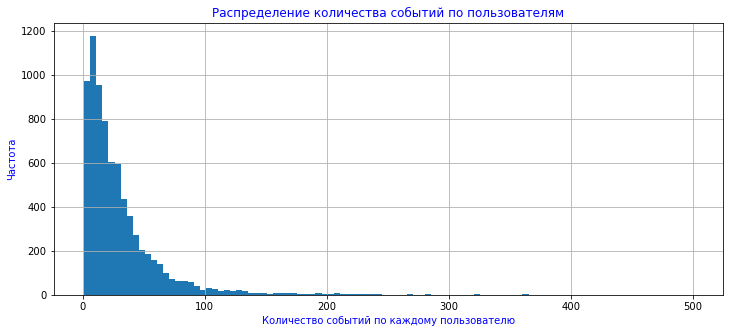

In [43]:
plt.figure(figsize=(12,5))
pd.Series(user_gr['event_name']).hist(bins=100, range = (1, 500))
plt.title('Распределение количества событий по пользователям', fontsize=12, color='blue')
plt.xlabel('Количество событий по каждому пользователю', fontsize=10, color='blue')
plt.ylabel('Частота', fontsize=10, color='blue')
plt.show()

In [44]:
print('медиана', user_gr['event_name'].median())
print('мода', user_gr['event_name'].mode())

медиана 20.0
мода 0    5
dtype: int64


Гистограмма распределения имеет высокий пик и очень длинный хвост, поскольку есть пользователи с количеством событий свыше 500 и даже свыше 1000, поэтому среднее плохо описывает данное распределение, в данном случае при наличии большого количества выбросов медиана не так сильно будет искажаться и лучше опишет распределение, посчитаем ее.

Получаем, что обычно пользователи совершали по 20 событий за указанный период.

Посмотрим на количество событий на пользователя в разрезе видов событий, для этого объединим таблицы unique_evens_count и count_unique_user по полю event_name и добавим столбец  count_per_user

In [45]:
event_per_user = pd.merge(unique_events_count, count_unique_user, on='event_name',how='outer')
event_per_user['count_event_per_user'] = event_per_user['count_event'] / event_per_user['count_unique_users'] 
event_per_user

,event_name,count_event,count_unique_users,count_event_per_user
0,MainScreenAppear,119101,7439,16.010351
1,OffersScreenAppear,46808,4613,10.146976
2,CartScreenAppear,42668,3749,11.381168
3,PaymentScreenSuccessful,34118,3547,9.618833
4,Tutorial,1018,847,1.201889


В среднем 16 раз пользователь открывает главный экран, 10 раз просматривает предложения, 11 раз кладет товар в корзину, 9 раз успешно оплачивает товар и 1 раз смотрит инструкцию. Странно, среднее количество событий товар в корзине больше чем среднее количество события просмотр предложения, видимо в данных есть какой-то перекос, рассмотрим подробнее дальше.

### 3.4 Проверка полноты данных за период <a id="analazed_period"> </a> 

Посмотрим за какой период имеются данные в логах, рассчитаем мin и max значение даты

In [46]:
print('период с', min(logs_exp['event_date']), 'по', max(logs_exp['event_date']))

период с 2019-07-25 00:00:00 по 2019-08-07 00:00:00


Мы располагаем данными логов за две недели с 25 июля по 7 августа 2019 года

In [83]:
logs_exp.sort_values(by='event_date').head()

,event_name,user_id,event_date_time,exp_id,event_date,event_time,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42,11


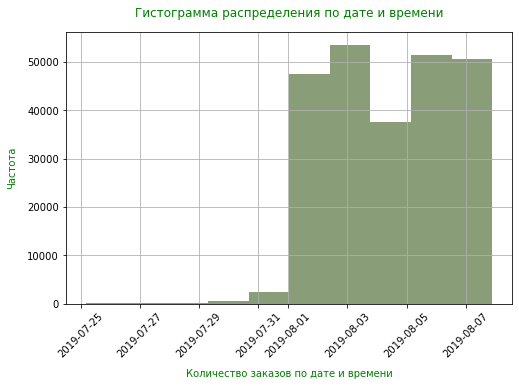

In [48]:
plt.figure(figsize=(8, 5))
plt.hist(logs_exp['event_date_time'], color='#8a9d79')
plt.title('Гистограмма распределения по дате и времени', fontsize=12, color='green', pad = 15)
plt.xlabel('Количество заказов по дате и времени', fontsize=10, color='green', labelpad=10)
plt.ylabel('Частота', fontsize=10, color='green', labelpad=10)
plt.xticks(rotation = 45)
plt.grid()
plt.show()

Сделаем срез из таблицы за 31.07.2019 и посмотрим гистограмму по часам

In [84]:
logs_exp_31 = logs_exp[logs_exp['event_date'] == "2019-07-31"]
logs_exp_31.head()

,event_name,user_id,event_date_time,exp_id,event_date,event_time,hour
797,MainScreenAppear,3670880358399219515,2019-07-31 01:11:46,247,2019-07-31,01:11:46,1
798,OffersScreenAppear,3799109751993694887,2019-07-31 01:21:04,248,2019-07-31,01:21:04,1
799,Tutorial,1126021718529336913,2019-07-31 01:32:11,247,2019-07-31,01:32:11,1
800,MainScreenAppear,4293428370257583636,2019-07-31 02:19:18,248,2019-07-31,02:19:18,2
801,MainScreenAppear,4567464647598975872,2019-07-31 02:33:30,247,2019-07-31,02:33:30,2


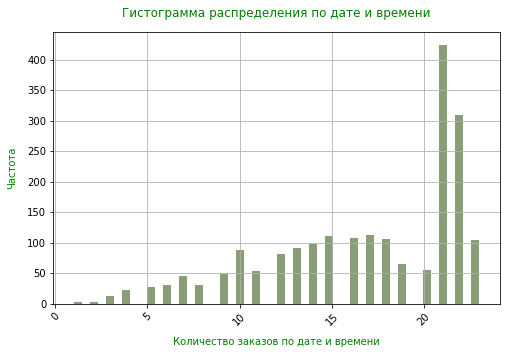

In [50]:
plt.figure(figsize=(8, 5))
plt.hist(logs_exp_31['hour'], bins=50, color='#8a9d79')
plt.title('Гистограмма распределения по дате и времени', fontsize=12, color='green', pad = 15)
plt.xlabel('Количество заказов по дате и времени', fontsize=10, color='green', labelpad=10)
plt.ylabel('Частота', fontsize=10, color='green', labelpad=10)
pl.xticks(rotation = 45)
plt.grid()
plt.show()

Получается, что данные не одинаково полные за весь период, вероятно в первую неделю с 25 июля по 31 июля у нас в логи 'доезжают события' из прошлого периода, полные данные начинают формироваться с 21 часа 31.07.2019, в связи с этим сделаем срез и отбросим данные до 21:00 31.07.2019, сохраним в новую таблицу logs_filtered

In [85]:
logs_filtered = logs_exp.query('event_date_time >= "2019-07-31 21:00:00"')
logs_filtered.head()

,event_name,user_id,event_date_time,exp_id,event_date,event_time,hour
1990,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31,21:00:57,21
1991,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31,21:01:45,21
1992,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31,21:02:21,21
1993,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31,21:02:23,21
1994,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31,21:03:25,21


Посмотрим насколько сократилась таблица с логами

In [52]:
print('из таблицы исключили', logs_exp.shape[0]-logs_filtered.shape[0], 'записей')

из таблицы исключили 1989 записей


In [53]:
unique_users_new = logs_filtered['user_id'].nunique()
print('из таблицы исключили:', count_users - unique_users_new, 'пользователей')

из таблицы исключили: 13 пользователей


Итого, отбросив старые данные, мы исключили 1989 записей по 13 пользователям.

### 3.5  Проверка наличия пользователей экпериментальных групп<a id="experimen_group"> </a>

Убедимся, что после исключения записей, у нас остались пользователи по всем экспериментальным группам, сделаем группировку по группе эксперимента с подсчетом пользователей

In [54]:
count_user_gr = logs_filtered.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index() \
                                .rename(columns={'user_id':'count_users_exp'})
count_user_gr

,exp_id,count_users_exp
0,246,2484
1,247,2517
2,248,2537


После исключения записей, в выборке присутствуют пользователи всех трех экпериментальных групп, в группе 246 - 2484 пользователя, в группе 247 - 2517 и в группе 248 - 2537 пользователей

In [55]:
event_per_user

,event_name,count_event,count_unique_users,count_event_per_user
0,MainScreenAppear,119101,7439,16.010351
1,OffersScreenAppear,46808,4613,10.146976
2,CartScreenAppear,42668,3749,11.381168
3,PaymentScreenSuccessful,34118,3547,9.618833
4,Tutorial,1018,847,1.201889


## Вывод

    В логах 5 уникальных событий:  
    - 119101 событий просмотров главного экрана, 
    - 46808 событий просмотра предложений, 
    - 42668 событий перехода в корзину, 
    - 34118 событий успешной оплаты, 
    - 1018 событий просмотра инструкции. 
    - Общее количество событий составляет 244126.
    7551 уникальных пользователей совершали какие-либо действия в приложении. В среднем на одного пользователя приходится 32 события, при этом:
    - в среднем 16 раз пользователь открывает главный экран, 
    - 10 раз просматривает предложения, 
    - 11 раз кладет товар в корзину, 
    - 9 раз успешно оплачивает товар,
    - 1 раз смотрит инструкцию. 
    Можно заметить, что среднее количество событий - товар в корзине больше чем среднее количество события просмотр предложения, видимо в данных есть какой-то перекос, что подтверждается распределением событий по датам и времени. 
    Мы располагаем данными логов за две недели с 25 июля по 7 августа 2019 года. Данные не одинаково полные за весь период, есть перекос, вероятно в первую неделю с 25 июля по 31 июля в логи 'доезжают события' из прошлого периода, полные данные начинают формироваться с 21 часа 31.07.2019, поэтому мы отбросили данные до 01.08.2019. Структурно, были исключены 2828 записей по 17 пользователям. Мы убедились, что после исключения записей, в выборке присутствуют пользователи всех трех экпериментальных групп, в группе 246 - 2484 пользователя, в группе 247 - 2517 и в группк 248 - 2537 пользователей.

## 4. Анализ воронки событий <a id="event_funnel"> </a> 

### 4.1 Оценка частоты событий в логах <a id="event_log"> </a>

Посмотрим частоту разных событий по отфильтрованым логам

In [56]:
count_events = logs_filtered.groupby('event_name').agg({'user_id': 'count'}) \
                                .rename(columns={'user_id':'count_event'}) \
                                .sort_values(by='count_event', ascending=False) \
                                .reset_index()
count_events

,event_name,count_event
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


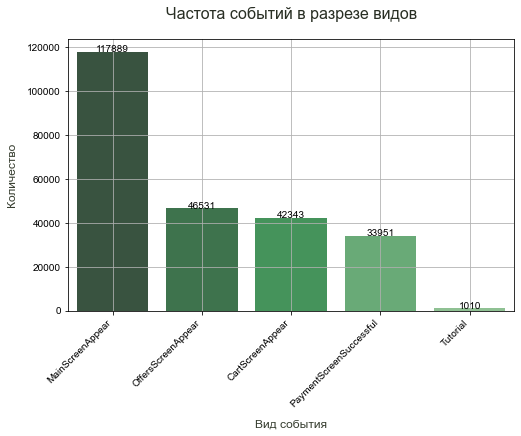

In [57]:
plt.figure(figsize=(8, 5))
pal = sns.color_palette("Greens_d", len(count_events))
rank = count_events["count_event"].argsort().argsort() 
g=sns.barplot(x="event_name", y="count_event", data=count_events, palette=np.array(pal[::-1])[rank])
sns.set_style('darkgrid')

plt.title('Частота событий в разрезе видов', fontsize=16, color='#292f24', pad = 20)
plt.xlabel('Вид события', fontsize=12, color='#373e30', labelpad=10)
plt.ylabel('Количество', fontsize=12, color='#373e30', labelpad=10)
plt.xticks(rotation=45, ha='right')
for index, row in count_events.iterrows():
    g.text(row.name,row.count_event, round(row.count_event,2), color='black', ha="center")
plt.grid()
plt.show()

Чаще всего встречается событие просмотр главного экрана - 117889 раз, затем просмотр предложений - 46531, потом товар кладут в корзину 42343 раз, успешная оплата товара - 33951 и просмотр инструкции 1010 событий

### 4.2 Анализ событий в разрезе пользователей <a id="event_users"> </a>

Посчитаем сколько пользователей совершали каждое из этих событий

In [58]:
count_user_filt = logs_filtered.groupby('event_name').agg({'user_id': 'nunique'}).reset_index() \
                                .rename(columns={'user_id':'count_users'})
count_user_filt

,event_name,count_users
0,CartScreenAppear,3736
1,MainScreenAppear,7423
2,OffersScreenAppear,4597
3,PaymentScreenSuccessful,3540
4,Tutorial,843


Объединим таблицы count_events и count_user_filt и посчитаем долю пользователей, которые хоть раз совершали какое-либо событие, для этого число уникальных пользователей каждого события разделим на общее число уникальных пользователей отфильтрованной выборки

In [59]:
event_per_user_filt = pd.merge(count_events, count_user_filt, on='event_name',how='outer') #объединяем таблицы
event_per_user_filt['ratio'] = (event_per_user_filt['count_users'] / unique_users_new * 100).round(2) #считаем долю пользователей
event_per_user_filt

,event_name,count_event,count_users,ratio
0,MainScreenAppear,117889,7423,98.47
1,OffersScreenAppear,46531,4597,60.98
2,CartScreenAppear,42343,3736,49.56
3,PaymentScreenSuccessful,33951,3540,46.96
4,Tutorial,1010,843,11.18


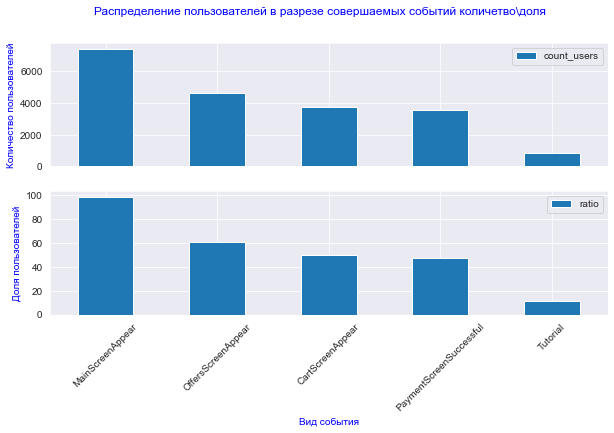

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5));
fig.suptitle('Распределение пользователей в разрезе совершаемых событий количетво\доля', fontsize=12, color='blue')
event_per_user_filt.plot(x='event_name', y='count_users', kind="bar", sharex=True, ax=axes[0])
event_per_user_filt.plot(x='event_name', y='ratio', kind="bar", ax=axes[1])
axes[0].set_ylabel('Количество пользователей', color='blue')
axes[1].set_ylabel('Доля пользователей', color='blue')
axes[-1].set_xlabel('Вид события', color='blue')
plt.xticks(rotation = 45)
plt.show()


Получаем, что 98,47% пользователей просматривали главный экран, 60,98% просматривали предложения, 49,56% клали товар в корзину, 46,96% оплачивала успешно и 11,18% смотрели инструкцию.

### 4.3 Анализ цепочки событий <a id="chain_of_events"> </a> 

Исходя из уже проведенного выше исследования, мы можем предположить следующую последовательную цепочку событий:
    1. Просмотр главного экрана - MainScreenAppear
    2. Просмотр предложений - OffersScreenAppear
    3. Товар в корзине - CartScreenAppear
    4. Успешная оплата заказа - PaymentScreenSuccessful

Событие о просмотре инструкции Tutorial	- нельзя поставить в последовательную цепочку, поскольку это событие может наступить не зависимо от всех остальных, поэтому его не будем учитывать при расчете воронки.

### 4.4 Построение воронки событий <a id="conversion"> </a>

Оставим в таблице все события, кроме просмотра инструкции, сохраним ее под именем event_funnel, добавим столбец conversion, в котором посчитаем отношение количества пользователей на каждом этапе к общему количеству пользователей

In [86]:
event_funnel = event_per_user_filt[0:4]
event_funnel['conversion']=(event_funnel['count_users'] / count_users *100).round(2)


<ipython-input-86-3f6afa9d6865>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



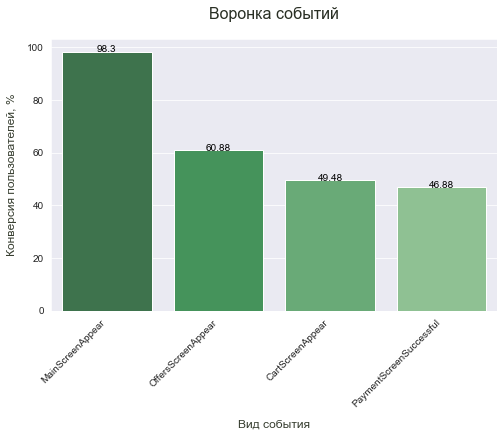

In [62]:
plt.figure(figsize=(8, 5))
pal = sns.color_palette("Greens_d", len(count_events))
rank = event_funnel["conversion"].argsort().argsort() 
g=sns.barplot(x="event_name", y="conversion", data=event_funnel, palette=np.array(pal[::-1])[rank])
sns.set_style('darkgrid')

plt.title('Воронка событий', fontsize=16, color='#292f24', pad = 20)
plt.xlabel('Вид события', fontsize=12, color='#373e30', labelpad=10)
plt.ylabel('Конверсия пользователей, %', fontsize=12, color='#373e30', labelpad=10)
plt.xticks(rotation=45, ha='right')
for index, row in event_funnel.iterrows():
    g.text(row.name,row.conversion, round(row.conversion,2), color='black', ha="center")
plt.show()

Получаем, что из 7551 пользователей,  98,3% просмотрели главный экран, 60,88% перешли на страницу просмотра предложений, затем 49,48% положили товары в корзину и наконец 46,48% пользователей успешно произвели оплату. Можно сделать вывод, что больше всего пользователей теряется на самом первом шаге после просмотра главной страницы, в результате чего только 46,48% пользователей от первого шага доходят до оплаты товаров.

## Вывод

    Исходя из уже проведенного исследования, мы можем предположить следующую последовательную цепочку событий: 1. Просмотр главного экрана - MainScreenAppear, 2. Просмотр предложений - OffersScreenAppear, 3. Товар в корзине - CartScreenAppear, 4. Успешная оплата заказа - PaymentScreenSuccessful
    Событие о просмотре инструкции Tutorial - нельзя поставить в последовательную цепочку, поскольку это событие может наступить не зависимо от всех остальных, поэтому его не будем учитывать при расчете воронки. В результате построения воронки, получаем, что изначалько не все пользователи просматривают главный экран, а только 98,3%, возможно некоторые приходят в приложение по ссылкам на конкретный товар, больше всего пользователей теряется на самом первом шаге после просмотра главной страницы (60,88% пользователей идут дальше), в результате чего 46,88% пользователей от общего количества доходят до оплаты товаров. 

## 5. А/А/В эксперимент <a id="experiment"> </a>

 ### 5.1 Подсчет количества пользователей в каждой экприментальной группе <a id="cont_group"> </a> 

In [63]:
count_user_gr

,exp_id,count_users_exp
0,246,2484
1,247,2517
2,248,2537


In [64]:
count_user246 = count_user_gr[count_user_gr['exp_id'] == 246].iloc[0]['count_users_exp']
count_user247 = count_user_gr[count_user_gr['exp_id'] == 247].iloc[0]['count_users_exp']
count_user248 = count_user_gr[count_user_gr['exp_id'] == 248].iloc[0]['count_users_exp']

В группе 246 - 2484 пользователя, в группе 247 - 2513 и в группе 248 - 2537 пользователей.

 ### 5.2 Оценка статистической значимости между контрольными группы для А/А-эксперимента<a id="A_A"> </a> 

Проверим, находят ли статистические критерии разницу между выборками 246 и 247, для этого сперва посчитаем количество пользователей на каждом этапе воронки в разрезе экспериментальных групп

In [65]:
my_list = ['Tutorial']
logs_filtered_funnel = logs_filtered.loc[~logs_filtered.event_name.isin(my_list)]


Добавим в таблицу строчку с общим количеством пользователей по каждой экспериментальной группе, назовем TotalUsers

In [66]:
count_user_exp = logs_filtered_funnel.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique') \
                        .rename(columns={246:'group_246', 247:'group_247', 248:'group_248'}).reset_index()
count_user_exp.loc[count_user_exp.shape[0]] = {'event_name': 'TotalUsers', 'group_246':count_user246, 'group_247':count_user247, 'group_248':count_user248}
count_user_exp

exp_id,event_name,group_246,group_247,group_248
0,CartScreenAppear,1266,1239,1231
1,MainScreenAppear,2450,2479,2494
2,OffersScreenAppear,1542,1524,1531
3,PaymentScreenSuccessful,1200,1158,1182
4,TotalUsers,2484,2517,2537


In [67]:
count_user_exp['total_count'] = count_user_exp['group_246'] + count_user_exp['group_247']+count_user_exp['group_248']
count_user_exp['group_246+247'] = count_user_exp['group_246'] + count_user_exp['group_247']
count_user_exp = count_user_exp.sort_values(by='total_count', ascending=False).reset_index(drop=True)
count_user_exp

exp_id,event_name,group_246,group_247,group_248,total_count,group_246+247
0,TotalUsers,2484,2517,2537,7538,5001
1,MainScreenAppear,2450,2479,2494,7423,4929
2,OffersScreenAppear,1542,1524,1531,4597,3066
3,CartScreenAppear,1266,1239,1231,3736,2505
4,PaymentScreenSuccessful,1200,1158,1182,3540,2358


Примем критический уровень статистической значимости alpha = .05

In [68]:
alpha = .05

    Сформируем нулевую и альтернативную гипотезы:
    H0 - нулевая гипотеза, между долями клиентов в разных группах нет значимой разницы
    H1 -есть значимая разница

Зададим функцию для расчета критерия

In [69]:
count_users

7551

In [70]:
def z_func(successes, trials):
    p1 = successes[0]/trials[0] #пропорция успехов в группе 246
    p2 = successes[1]/trials[1] #пропорция успехов в группе 247
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])#пропорция успехов в комбинированной группе
    difference = p1 - p2 #разница в датасетах
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))#Считаем статистику
    distr = st.norm(0, 1)#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        return("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        return("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Вызовем функцию, cравним доли клиентов группе 246 и 247

In [71]:
def z_funnel (group_1,group_2):
    for i in range (1,count_user_exp.shape[0]):
        print('cравним доли клиентов группе',group_1,'и',group_2,', совершивших событие:',count_user_exp.loc[i]['event_name'])
        #print (count_user_exp.loc[i][group_1],count_user_exp.loc[i][group_2], count_user_exp.loc[i-1][group_1], count_user_exp.loc[i-1][group_2])
        rez=z_func(np.array([count_user_exp.loc[i][group_1], count_user_exp.loc[i][group_2]]), np.array([count_user_exp.loc[0][group_1], count_user_exp.loc[0][group_2]]))
        print(rez)
        print('-----------')

In [72]:
z_funnel ('group_246','group_247')

cравним доли клиентов группе group_246 и group_247 , совершивших событие: MainScreenAppear
p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_247 , совершивших событие: OffersScreenAppear
p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_247 , совершивших событие: CartScreenAppear
p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_247 , совершивших событие: PaymentScreenSuccessful
p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------


Такая разница на всех этапах воронки в пропорциях при указанных размерах выборок групп 246 и 247 не достаточна, чтобы говорить о статистически значимом различии. Соответсвенно группы 246 и 247 сформированы верно, различий и не должно было быть

 ### 5.3 Оценка самого популярного события в разных группах<a id="popular_event"> </a> 

In [73]:
count_user_exp

exp_id,event_name,group_246,group_247,group_248,total_count,group_246+247
0,TotalUsers,2484,2517,2537,7538,5001
1,MainScreenAppear,2450,2479,2494,7423,4929
2,OffersScreenAppear,1542,1524,1531,4597,3066
3,CartScreenAppear,1266,1239,1231,3736,2505
4,PaymentScreenSuccessful,1200,1158,1182,3540,2358


Самым популярным событием во всех экспериментальных группах является просмотр главного экрана, в группе 246 его совершили 2540 пользователей, в группе 247 - 2476 пользователей и в группе 248 - 2493 пользователя. Сравним доли пользователей совершивших данное событие попарно среди всех групп

In [74]:
t_count_max=count_user_exp.loc[0]['total_count']
max246=count_user_exp.loc[1]['group_246']
max247=count_user_exp.loc[1]['group_247']
max248=count_user_exp.loc[1]['group_248']
z_func(np.array([max246,max247]), np.array([t_count_max, t_count_max]))

p-значение:  0.614618200925189


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [75]:
z_func(np.array([max247,max248]), np.array([t_count_max, t_count_max]))

p-значение:  0.7949900056502037


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [76]:
z_func(np.array([max246,max248]), np.array([t_count_max, t_count_max]))

p-значение:  0.4452701904327818


'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

Можно сделать вывод, что разбиение на группы работает корректно

 ### 5.4 A/B тест<a id="A_B"> </a> 

Вызовем функцию, cравним доли клиентов группе 246 и 248

In [77]:
z_funnel ('group_246','group_248')

cравним доли клиентов группе group_246 и group_248 , совершивших событие: MainScreenAppear
p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_248 , совершивших событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_248 , совершивших событие: CartScreenAppear
p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_246 и group_248 , совершивших событие: PaymentScreenSuccessful
p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------


Вызовем функцию, cравним доли клиентов группе 247 и 248

In [78]:
z_funnel ('group_247','group_248')

cравним доли клиентов группе group_247 и group_248 , совершивших событие: MainScreenAppear
p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_247 и group_248 , совершивших событие: OffersScreenAppear
p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_247 и group_248 , совершивших событие: CartScreenAppear
p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_247 и group_248 , совершивших событие: PaymentScreenSuccessful
p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------


Вызовем функцию, cравним доли клиентов в объединенной группе и группе 248

In [79]:
z_funnel ('group_248','group_246+247')

cравним доли клиентов группе group_248 и group_246+247 , совершивших событие: MainScreenAppear
p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_248 и group_246+247 , совершивших событие: OffersScreenAppear
p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_248 и group_246+247 , совершивших событие: CartScreenAppear
p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------
cравним доли клиентов группе group_248 и group_246+247 , совершивших событие: PaymentScreenSuccessful
p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------


Получаем, что статистическую значимость между долями пользователей объединенной группы и 248 отсутствует. Т.е. можно сделать вывод, что изменение шрифта не приводит к увеличению конверсии.

Итого мы сделали 13 проверок гипотез с уровнем значимости 0.05, считаю такой уровень значимости достаточным для проверки гипотез

# Вывод<a id="resume"> </a> 

    При выполнении работы, был выполнен первичный анализ данных и предобработка, в ходе которой, изменили тип данных столбца event_date_time, поправили названия столбцов, добавили два стоблца содержащих отдельно дату и время события.
    В ходе анализа логов был выявлен перекос данных, они не одинаково полные за весь период, вероятно в первую неделю с 25 июля по 31 июля в логи 'доезжают события' из прошлого периода, полные данные начинают формироваться с 21 часа 31.07.2019, поэтому мы отбросили данные до указанного времени. Структурно, были исключены 1989 записей по 13 пользователям. Мы убедились, что после исключения записей, в выборке присутствуют пользователи всех трех экпериментальных групп, в группе 346 - 2484 пользователя, в группе 247 - 2517 и в группе 248 - 2537 пользователей.
    Исходя из уже проведенного исследования, мы можем предположить следующую последовательную цепочку событий: 1. Просмотр главного экрана - MainScreenAppear, 2. Просмотр предложений - OffersScreenAppear, 3. Товар в корзине - CartScreenAppear, 4. Успешная оплата заказа - PaymentScreenSuccessful
    Событие о просмотре инструкции Tutorial - нельзя поставить в последовательную цепочку, поскольку это событие может наступить не зависимо от всех остальных, поэтому его не будем учитывать при расчете воронки. В результате построения воронки, получаем, что изначалько не все пользователи просматривают главный экран, а только 98,3%, возможно некоторые приходят в приложение по ссылкам на конкретный товар, больше всего пользователей теряется на самом первом шаге после просмотра главной страницы (60,88% пользователей идут дальше), в результате чего 46,88% пользователей от общего количества доходят до оплаты товаров. 
    А/А тест оценки статистической значимости между контрольными группами 246 и 247 показал, что разбиение на группы работает корректно. В итоге A/B эксперимента получили, что статистическую значимость между долями контрольных и тестовой групп отсутствует. Т.е. можно сделать вывод, что в изменение шрифта не приводит к увеличению конверсии, соответствено не увеличивает покупки
    